# Семинар 08 - Нейросети

In [ ]:
!pip install torchvision

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
# warnings.simplefilter('ignore')
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch
print(torch.__version__)

D:\Anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2.1.0+cu121


<a id="Content"></a>
# Содержание
0. [Вспомним PyTorch](#0)
1. [Подготовка данных](#1)
2. [Определим архитектуру нейросети в PyTorch](#2)
3. [Что мы можем улучшить?](#3)
   - [Нормировка](#3.1)
   - [Функции активации](#3.2)
   - [Инициализация весов](#3.3)
   - [Влияние метода оптимизации градиентного спуска](#3.4)
   - [Влияние скорости обучения](#3.5)
4. [Полезные ссылки](#4)

<a id="0"></a>
# 0. Вспомним PyTorch

Нахождение сложной производной

Найдите производную по x от функции
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [12]:
def find_x_derivative(x, y):
    x_with_grad = torch.tensor([float(x)], requires_grad=True)
    y_with_grad = torch.tensor([float(y)], requires_grad=True)

    z = torch.sin(torch.tan(x_with_grad)*(x_with_grad**2/y_with_grad) + torch.log(torch.exp(-x_with_grad**2+3) + y_with_grad*x_with_grad**3))*torch.tan(torch.exp(x_with_grad**9)*x_with_grad**2)
    z.backward()

    dz_dx = x_with_grad.grad
    return dz_dx.item(), z

In [13]:
find_x_derivative(1,21)

(-9.020709991455078, tensor([0.1239], grad_fn=<MulBackward0>))

<a id="1"></a>
# 1. Подготовка данных

### В семинаре, будем использовать набор данных `fashion_mnist`, загрузим их

In [14]:
from torchvision import datasets, transforms

In [16]:
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train = True, download=True)

100%|██████████████████████████████████████████████████████████████████| 26421880/26421880 [02:06<00:00, 209185.97it/s]


Extracting C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 348378.43it/s]


Extracting C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:19<00:00, 222112.75it/s]


Extracting C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]


Extracting C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Arina/.pytorch/F_MNIST_data/FashionMNIST\raw



In [17]:
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train = False, download = True)

In [18]:
num_classes = len(trainset.classes)

In [19]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [21]:
x_train = trainset.data
y_train = trainset.targets

x_test = testset.data
y_test = testset.targets

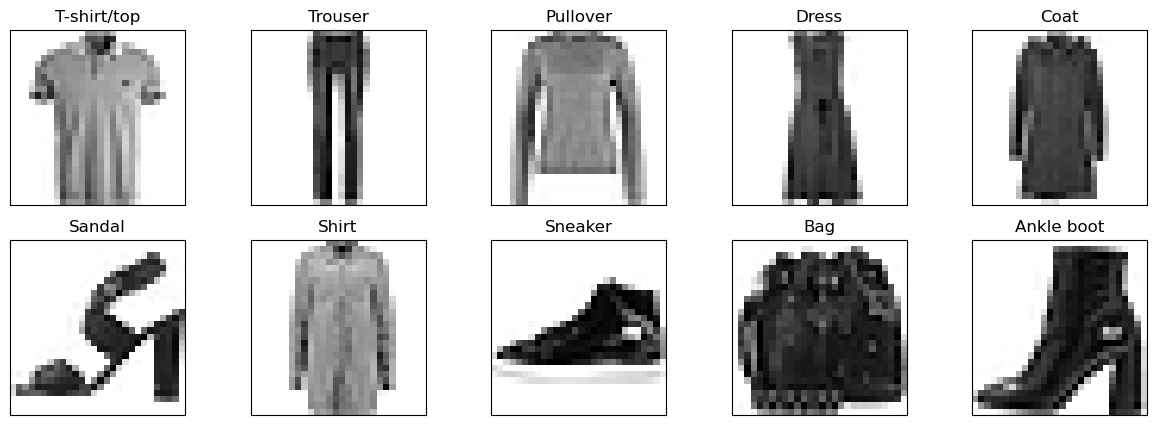

In [22]:
fig = plt.figure(figsize=(15,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(trainset.classes[i])
    plt.imshow(im, cmap='gray_r')
plt.show()

### Проведем небольшие предобработки

In [23]:
x_train_flat = x_train.flatten(start_dim=1).float()
x_test_flat = x_test.flatten(start_dim=1).float()
print(f'Была размерность: {x_train.shape}, стала: {x_train_flat.shape}')
print(f'Была размерность: {x_test.shape}, стала: {x_test_flat.shape}')

Была размерность: torch.Size([60000, 28, 28]), стала: torch.Size([60000, 784])
Была размерность: torch.Size([10000, 28, 28]), стала: torch.Size([10000, 784])


In [24]:
D_out = num_classes
D_in = x_train_flat.shape[1]

<a id="2"></a>
# 2. Определим архитектуру нейросети в PyTorch

Вариантов определения архитектуры много, рассмотрим 2 наиболее популярных варианта

In [25]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, 128),
    torch.nn.Sigmoid(),
    torch.nn.Linear(128, 10),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10, D_out),
    torch.nn.Softmax(dim=1)
)

In [26]:
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, 128)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(128, 10)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(10, D_out)
        self.act3 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

model = Model()

In [27]:
model

Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (act2): Sigmoid()
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (act3): Softmax(dim=1)
)

In [28]:
# Forward pass: compute predicted y by passing x to the model. Module objects
# override the __call__ operator so you can call them like functions. When
# doing so you pass a Tensor of input data to the Module and it produces
# a Tensor of output data.
y_pred = model(x_train_flat)

In [29]:
y_pred.shape

torch.Size([60000, 10])

In [30]:
loss_fn = torch.nn.CrossEntropyLoss()

In [31]:
# Compute and print loss. We pass Tensors containing the predicted and true
# values of y, and the loss function returns a Tensor containing the
# loss.
loss_old = loss_fn(y_pred, y_train)
loss_old

tensor(2.3027, grad_fn=<NllLossBackward0>)

In [32]:
acc_old = accuracy_score(y_train.numpy(), y_pred.argmax(dim=1))
acc_old

0.1412

In [33]:
# Zero the gradients before running the backward pass.
model.zero_grad()

In [34]:
# Backward pass: compute gradient of the loss with respect to all the learnable
# parameters of the model. Internally, the parameters of each Module are stored
# in Tensors with requires_grad=True, so this call will compute gradients for
# all learnable parameters in the model.
loss_old.backward()

In [35]:
learning_rate = 1e-2

**Задание 0:** Обновите веса, используя градиентный спуск. 

*Hint:* Каждый параметр - это тензор из PyTorch, так что градиенты можно получить так же, как мы это делали в начале семинара. Параметры для обновления хранятся в model.parameters()

In [40]:
# Update the weights using gradient descent. Each parameter is a Tensor, so
# we can access its gradients like we did before.
with torch.no_grad():
    # YOUR CODE HERE
    for param in model.parameters():
        param -= learning_rate*param.grad

In [41]:
y_pred = model(x_train_flat.float())
loss_new = loss_fn(y_pred, y_train)
step = loss_new.item()-loss_old.item()

acc_new = accuracy_score(y_train, y_pred.argmax(dim=1))

print(f'Лосс: {loss_old.item()} -> {loss_new.item()}. Step {step} ')
print(f'Accuracy: {acc_old} -> {acc_new}')

Лосс: 2.302731990814209 -> 2.3027126789093018. Step -1.9311904907226562e-05 
Accuracy: 0.1412 -> 0.14226666666666668


**Задание 1:** Реализуйте обучение модели на одном батче.

In [42]:
def batch_train(model, loss_fn, learning_rate, x, y):
    # YOUR CODE HERE
    
    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate*param.grad

    return(loss.item())

In [43]:
def train(model, n_epochs, batch_size, learning_rate,  X, y, X_test, y_test):
    acc_train_all = []
    loss_train_all = []
    acc_test_all = []
    loss_test_all = []

    for epoch in range(n_epochs):

        permutation = torch.randperm(X.size()[0])

        for i in tqdm(range(0,X.float().size()[0], batch_size)):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], y[indices]
            batch_train(model, loss_fn, learning_rate, batch_x, batch_y)

        y_test_pred = model(X_test)
        y_train_pred = model(X)


        acc_train = accuracy_score(y, y_train_pred.argmax(dim=1))
        loss_train = loss_fn(y_train_pred, y).detach()
        acc_test = accuracy_score(y_test, y_test_pred.argmax(dim=1))
        loss_test = loss_fn(y_test_pred, y_test).detach()

        acc_train_all = np.append(acc_train_all, acc_train)
        loss_train_all = np.append(loss_train_all, loss_train)
        acc_test_all = np.append(acc_test_all, acc_test)
        loss_test_all = np.append(loss_test_all, loss_test)


        print(f'Epoch {epoch}: \n Accuracy - train: {acc_train} | test: {acc_test} \n Loss - train: {loss_train} | test: {loss_test}')

    return(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

In [44]:
n_epochs = 10
batch_size = 1000
learning_rate = 1
model = Model()
acc_train_all, loss_train_all, acc_test_all, loss_test_all = \
          train(model, n_epochs, batch_size, learning_rate, x_train_flat, y_train, x_test_flat, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 69.06it/s]


Epoch 0: 
 Accuracy - train: 0.25965 | test: 0.2589 
 Loss - train: 2.227034330368042 | test: 2.2273666858673096


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 71.56it/s]


Epoch 1: 
 Accuracy - train: 0.3740833333333333 | test: 0.3733 
 Loss - train: 2.134512424468994 | test: 2.13554310798645


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 84.77it/s]


Epoch 2: 
 Accuracy - train: 0.3789666666666667 | test: 0.3783 
 Loss - train: 2.065671682357788 | test: 2.066765546798706


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 89.02it/s]


Epoch 3: 
 Accuracy - train: 0.5327333333333333 | test: 0.5297 
 Loss - train: 1.9956474304199219 | test: 1.99802827835083


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 90.96it/s]


Epoch 4: 
 Accuracy - train: 0.62615 | test: 0.6239 
 Loss - train: 1.9300154447555542 | test: 1.932651400566101


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 89.29it/s]


Epoch 5: 
 Accuracy - train: 0.6395666666666666 | test: 0.6376 
 Loss - train: 1.8834114074707031 | test: 1.8862154483795166


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 84.96it/s]


Epoch 6: 
 Accuracy - train: 0.6358666666666667 | test: 0.6316 
 Loss - train: 1.871086597442627 | test: 1.8748213052749634


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 84.87it/s]


Epoch 7: 
 Accuracy - train: 0.6415666666666666 | test: 0.638 
 Loss - train: 1.8543145656585693 | test: 1.858101725578308


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 92.14it/s]


Epoch 8: 
 Accuracy - train: 0.6378166666666667 | test: 0.6323 
 Loss - train: 1.854641318321228 | test: 1.8586902618408203


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 86.10it/s]


Epoch 9: 
 Accuracy - train: 0.6429666666666667 | test: 0.6379 
 Loss - train: 1.8463393449783325 | test: 1.8506661653518677


In [45]:
def vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all):
    fig = plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)

    plt.plot(loss_train_all, label='loss')
    plt.plot(loss_test_all, label='val_loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_train_all, label='acc')
    plt.plot(acc_test_all, label='val_acc')

    plt.legend()
    plt.show()

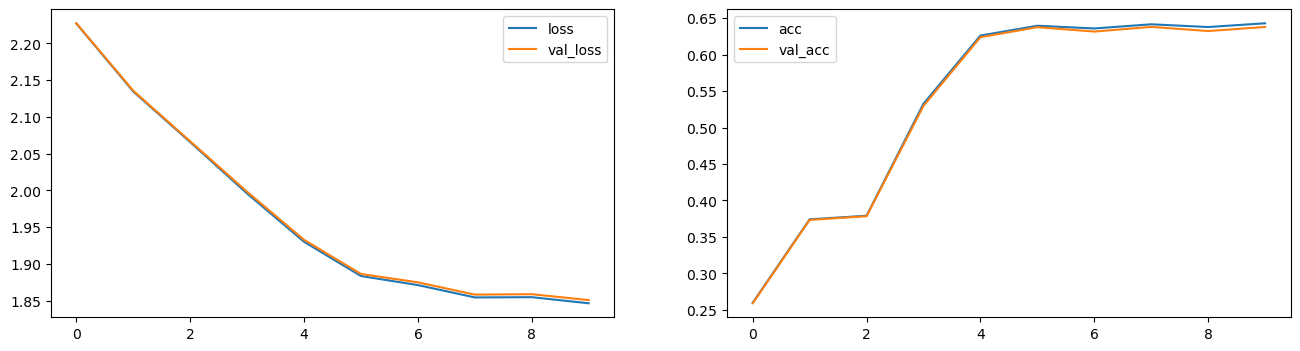

In [46]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3"></a>
# 3. Что мы можем улучшить?
- Отнормировать признаки
- Задать правила инициации весов
- Выбрать функцию активации
- Настроить скорость обучения

<a id="3.1"></a>
## 3.1. Нормировка
![picture](img/normalize.png)

![img](img/batch_norm.png)

In [47]:
import torch.nn.functional as F

class ModelNorm(torch.nn.Module):
    def __init__(self):
        super(ModelNorm, self).__init__()
        self.act1 = torch.nn.Sigmoid()
        self.fc1 = torch.nn.Linear(D_in, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 10)
        self.bn2 = torch.nn.BatchNorm1d(10)
        self.fc3 = torch.nn.Linear(10, D_out)
        self.act2 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act2(x)
        return x

model_norm = ModelNorm()

In [48]:
mean = x_train_flat.mean()
std = x_train_flat.std()

x_train_norm = (x_train_flat - mean) / std
x_test_norm = (x_test_flat - mean) / std

In [49]:
x_train_norm.max(), x_train_norm.min()

(tensor(2.0224), tensor(-0.8103))

In [50]:
n_epochs = 10
batch_size = 1000
learning_rate = 1
acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_norm, n_epochs, batch_size, learning_rate,
                                                                   x_train_norm, y_train, x_test_norm, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 99.81it/s]


Epoch 0: 
 Accuracy - train: 0.3878 | test: 0.3872 
 Loss - train: 2.2111189365386963 | test: 2.21232271194458


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 147.38it/s]


Epoch 1: 
 Accuracy - train: 0.45753333333333335 | test: 0.4537 
 Loss - train: 2.067929267883301 | test: 2.070427417755127


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 128.37it/s]


Epoch 2: 
 Accuracy - train: 0.4684833333333333 | test: 0.4679 
 Loss - train: 2.000011444091797 | test: 2.0030593872070312


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 147.03it/s]


Epoch 3: 
 Accuracy - train: 0.5506333333333333 | test: 0.5484 
 Loss - train: 1.9582312107086182 | test: 1.9610683917999268


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 135.47it/s]


Epoch 4: 
 Accuracy - train: 0.60455 | test: 0.6023 
 Loss - train: 1.9093281030654907 | test: 1.9127696752548218


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 152.64it/s]


Epoch 5: 
 Accuracy - train: 0.65345 | test: 0.6483 
 Loss - train: 1.8521257638931274 | test: 1.8569265604019165


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 151.07it/s]


Epoch 6: 
 Accuracy - train: 0.73195 | test: 0.7293 
 Loss - train: 1.7944165468215942 | test: 1.7992589473724365


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 145.08it/s]


Epoch 7: 
 Accuracy - train: 0.73695 | test: 0.7306 
 Loss - train: 1.764586329460144 | test: 1.7707300186157227


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 133.94it/s]


Epoch 8: 
 Accuracy - train: 0.7403333333333333 | test: 0.7334 
 Loss - train: 1.749241828918457 | test: 1.7559974193572998


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 121.38it/s]


Epoch 9: 
 Accuracy - train: 0.74935 | test: 0.7413 
 Loss - train: 1.7389168739318848 | test: 1.7470479011535645


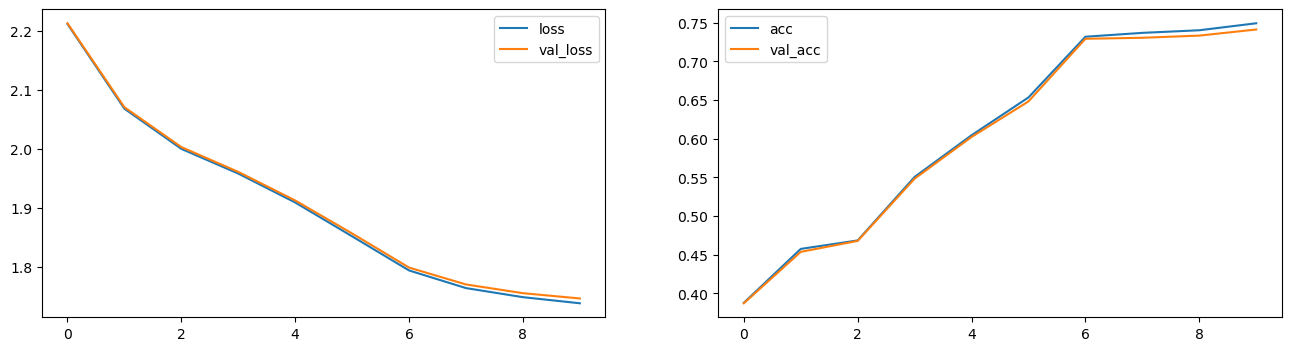

In [51]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3.2"></a>
## 3.2. Функции активации
![picture](img/activations.png)

In [52]:
class ModelReLU(torch.nn.Module):
    def __init__(self):
        super(ModelReLU, self).__init__()
        self.act1 = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(D_in, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 10)
        self.bn2 = torch.nn.BatchNorm1d(10)
        self.fc3 = torch.nn.Linear(10, D_out)
        self.act2 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act2(x)
        return x

model_relu = ModelReLU()

In [53]:
n_epochs = 10
batch_size = 1000
learning_rate = 1

acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_relu, n_epochs, batch_size, learning_rate, x_train_norm, y_train, x_test_norm, y_test)


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 111.17it/s]


Epoch 0: 
 Accuracy - train: 0.5498 | test: 0.5446 
 Loss - train: 1.8816039562225342 | test: 1.888225793838501


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 146.33it/s]


Epoch 1: 
 Accuracy - train: 0.7756166666666666 | test: 0.7636 
 Loss - train: 1.7249199151992798 | test: 1.7356572151184082


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 146.16it/s]


Epoch 2: 
 Accuracy - train: 0.8434 | test: 0.8266 
 Loss - train: 1.6679275035858154 | test: 1.6822938919067383


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 161.23it/s]


Epoch 3: 
 Accuracy - train: 0.8669166666666667 | test: 0.8466 
 Loss - train: 1.6358152627944946 | test: 1.6531137228012085


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 144.75it/s]


Epoch 4: 
 Accuracy - train: 0.8850666666666667 | test: 0.8653 
 Loss - train: 1.598507285118103 | test: 1.6188935041427612


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 153.04it/s]


Epoch 5: 
 Accuracy - train: 0.8887 | test: 0.8638 
 Loss - train: 1.5830999612808228 | test: 1.6053199768066406


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 151.50it/s]


Epoch 6: 
 Accuracy - train: 0.8966333333333333 | test: 0.8724 
 Loss - train: 1.5728274583816528 | test: 1.5967917442321777


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 148.14it/s]


Epoch 7: 
 Accuracy - train: 0.89755 | test: 0.8671 
 Loss - train: 1.5713796615600586 | test: 1.5995653867721558


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 142.90it/s]


Epoch 8: 
 Accuracy - train: 0.8983166666666667 | test: 0.8714 
 Loss - train: 1.5695182085037231 | test: 1.5962496995925903


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 147.42it/s]


Epoch 9: 
 Accuracy - train: 0.9078 | test: 0.877 
 Loss - train: 1.5586646795272827 | test: 1.5884166955947876


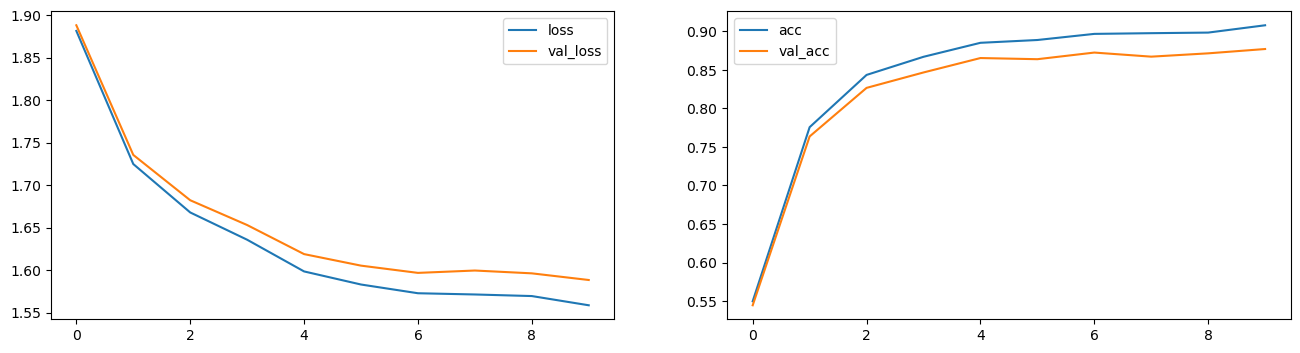

In [54]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3.3"></a>
## 3.3. Инициализация весов

__Случайно__  
$ w = a * N(0, 1)$, но тогда если $a \gg 1$, то на выходе $b\gg1$ и если $a \ll 1 $, то $b \approx 0 $  

$ D(w^T*x) = n*D(w)*D(x) $ar(x)

__Xavier__  
$a = \frac{1}{\sqrt{n}}$, где $n$ - кол-во нейронов на входе

__He__  
$a = \frac{1}{\sqrt{\frac{n}{2}}}$, где $n$ - кол-во нейронов на входе

In [56]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

Применим к модели  функцию инициации весов с помощью метода .apply()

In [57]:
model_relu = ModelReLU()

In [58]:
model_he = model_relu.apply(init_weights)

In [59]:
n_epochs = 10
batch_size = 1000
learning_rate = 1

acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_he, n_epochs, batch_size, learning_rate,
                                                                   x_train_norm, y_train, x_test_norm, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 87.88it/s]


Epoch 0: 
 Accuracy - train: 0.7996 | test: 0.7894 
 Loss - train: 1.6949808597564697 | test: 1.7040828466415405


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 131.26it/s]


Epoch 1: 
 Accuracy - train: 0.8484 | test: 0.8347 
 Loss - train: 1.6288186311721802 | test: 1.6420620679855347


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 138.91it/s]


Epoch 2: 
 Accuracy - train: 0.8566833333333334 | test: 0.8432 
 Loss - train: 1.6140865087509155 | test: 1.6284027099609375


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 145.99it/s]


Epoch 3: 
 Accuracy - train: 0.8642666666666666 | test: 0.845 
 Loss - train: 1.6057780981063843 | test: 1.6249030828475952


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 155.80it/s]


Epoch 4: 
 Accuracy - train: 0.86645 | test: 0.8473 
 Loss - train: 1.6020065546035767 | test: 1.6206761598587036


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 141.86it/s]


Epoch 5: 
 Accuracy - train: 0.8804 | test: 0.8539 
 Loss - train: 1.587243914604187 | test: 1.6104457378387451


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 156.63it/s]


Epoch 6: 
 Accuracy - train: 0.8882166666666667 | test: 0.8628 
 Loss - train: 1.578229546546936 | test: 1.603442907333374


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 138.27it/s]


Epoch 7: 
 Accuracy - train: 0.89305 | test: 0.8647 
 Loss - train: 1.5737817287445068 | test: 1.6008299589157104


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 132.91it/s]


Epoch 8: 
 Accuracy - train: 0.8910666666666667 | test: 0.863 
 Loss - train: 1.5757701396942139 | test: 1.6014697551727295


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 160.39it/s]


Epoch 9: 
 Accuracy - train: 0.8996333333333333 | test: 0.8688 
 Loss - train: 1.5657391548156738 | test: 1.5950403213500977


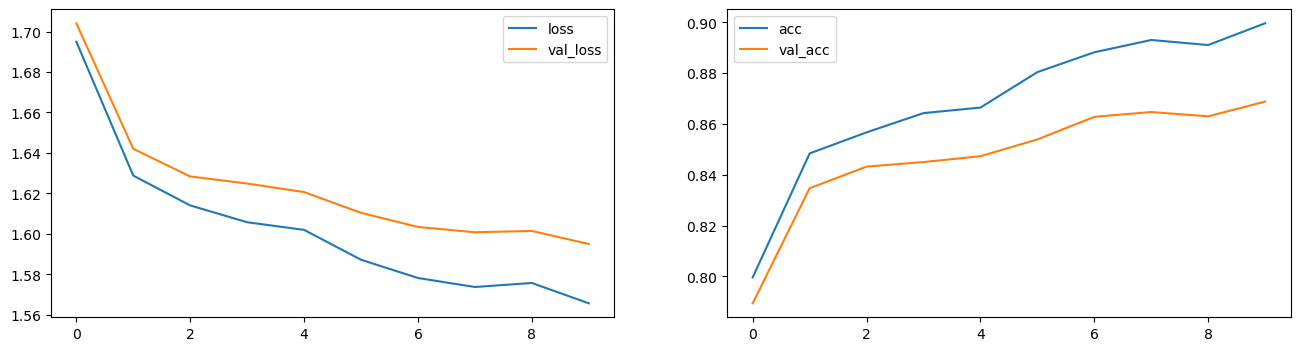

In [60]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="3.4"></a>
## 3.4. Влияние метода оптимизации градиентного спуска

![picture](img/optimizers7.gif)

**Momentum**

![img](img/momentum_formula.png)

Вместо того, чтобы использовать только градиент текущего шага, мы будем накапливать импульс градиента прошлых шагов для определения направления движения.
![img](img/momentum.jpg)

В связи со стохастической природой, обновления градиента происходят "зигзагообразно", с помощью момента мы усиливаем движение вдоль основного направления. На практике коэффициент у момента инициализируется на уровне 0,5 и постепенно увеличивается до 0,9 в течение нескольких эпох.
![img](img/sgd_momentum.jpg)
  
**RMSProp** (Root Mean Square Propogation)

Покомпонентно накапливаем квадрат векторов градиентов и используем в качестве нормировки. Коэффициент $\beta$ отвечает за то, что нам важнее сохранить, предыдущие градиенты или новые.

![image](img/rmsprop.png)

**Adam** (Adaptive momentum)

Используем и накопленный импульс, и накопленный квадрат градиентов

![image](img/adam.png)новления весов для типичных признаков

### Update batch train

In [61]:
def batch_train(model, optimizer, x, y):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return (loss.item())

### Prepare models

In [62]:
model_relu = ModelReLU()
model_he_SGD = model_relu.apply(init_weights)

In [63]:
model_relu = ModelReLU()
model_he_Momentum = model_relu.apply(init_weights)

In [64]:
model_relu = ModelReLU()
model_he_Adam = model_relu.apply(init_weights)

### Prepare optimizers

In [65]:
optimizerSGD = torch.optim.SGD(model_he_SGD.parameters(), lr=0.01, momentum=0.0)

In [66]:
optimizerMomentum = torch.optim.SGD(model_he_Momentum.parameters(), lr=0.01, momentum=0.9)

In [67]:
optimizerAdam = torch.optim.Adam(model_he_Adam.parameters(), lr=0.01)

### Train

In [68]:
n_epochs = 10
batch_size = 1000


loss_test_sgd = []
loss_test_sgd_moment = []
loss_test_adam = []

for epoch in range(n_epochs):

    permutation = torch.randperm(x_train_norm.size()[0])

    for i in tqdm(range(0,x_train_norm.float().size()[0], batch_size)):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train_norm[indices], y_train[indices]
        batch_train(model_he_SGD, optimizerSGD, batch_x, batch_y)
        batch_train(model_he_Momentum, optimizerMomentum, batch_x, batch_y)
        batch_train(model_he_Adam, optimizerAdam, batch_x, batch_y)

    y_test_pred = model_he_SGD(x_test_norm)
    loss_train = loss_fn(y_test_pred, y_test).detach().numpy()
    print(f' SGD Epoch: {epoch} loss {loss_train}')
    loss_test_sgd.append(loss_train)

    y_test_pred = model_he_Momentum(x_test_norm)
    loss_train = loss_fn(y_test_pred, y_test).detach().numpy()
    print(f' Momentum Epoch: {epoch} loss {loss_train}')
    loss_test_sgd_moment.append(loss_train)

    y_test_pred = model_he_Adam(x_test_norm)
    loss_train = loss_fn(y_test_pred, y_test).detach().numpy()
    print(f' Adam Epoch: {epoch} loss {loss_train}')
    loss_test_adam.append(loss_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.27it/s]


 SGD Epoch: 0 loss 2.2584598064422607
 Momentum Epoch: 0 loss 2.114394187927246
 Adam Epoch: 0 loss 1.699170708656311


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.86it/s]


 SGD Epoch: 1 loss 2.1968445777893066
 Momentum Epoch: 1 loss 2.043215036392212
 Adam Epoch: 1 loss 1.6252323389053345


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.12it/s]


 SGD Epoch: 2 loss 2.151888132095337
 Momentum Epoch: 2 loss 1.9961919784545898
 Adam Epoch: 2 loss 1.608061671257019


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 52.16it/s]


 SGD Epoch: 3 loss 2.1184134483337402
 Momentum Epoch: 3 loss 1.950531005859375
 Adam Epoch: 3 loss 1.5994218587875366


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 54.31it/s]


 SGD Epoch: 4 loss 2.0925419330596924
 Momentum Epoch: 4 loss 1.905349612236023
 Adam Epoch: 4 loss 1.5927021503448486


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 54.23it/s]


 SGD Epoch: 5 loss 2.070706367492676
 Momentum Epoch: 5 loss 1.8506025075912476
 Adam Epoch: 5 loss 1.5949535369873047


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 53.56it/s]


 SGD Epoch: 6 loss 2.0513432025909424
 Momentum Epoch: 6 loss 1.7992876768112183
 Adam Epoch: 6 loss 1.5918344259262085


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 53.39it/s]


 SGD Epoch: 7 loss 2.0337178707122803
 Momentum Epoch: 7 loss 1.7656155824661255
 Adam Epoch: 7 loss 1.5887634754180908


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 53.30it/s]


 SGD Epoch: 8 loss 2.0174710750579834
 Momentum Epoch: 8 loss 1.7412406206130981
 Adam Epoch: 8 loss 1.5834989547729492


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 53.56it/s]

 SGD Epoch: 9 loss 2.0024399757385254
 Momentum Epoch: 9 loss 1.7234244346618652
 Adam Epoch: 9 loss 1.5873984098434448


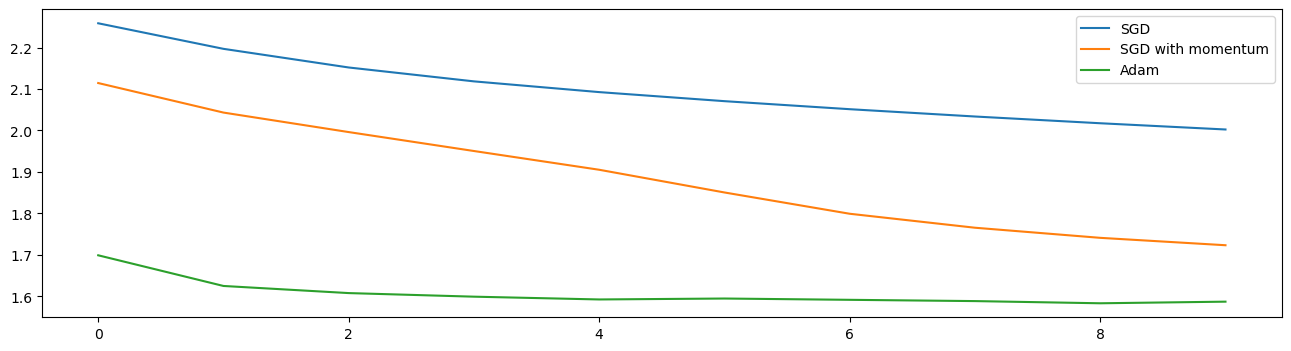

In [69]:
fig = plt.figure(figsize=(16, 4))

plt.plot(loss_test_sgd, label='SGD')
plt.plot(loss_test_sgd_moment, label='SGD with momentum')
plt.plot(loss_test_adam, label='Adam')

plt.legend()
plt.show()

<a id="3.5"></a>
## 3.5. Влияние скорости обучения
Посмотрим, как влияет параметр `learning_rate` на качество нашей модели на обучающей выборке

In [70]:
model_relu = ModelReLU()
model_he_Adam = model_relu.apply(init_weights)

In [71]:
optimizerAdam = torch.optim.Adam(model_he_Adam.parameters(), lr=0.01)

In [72]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.LinearLR(optimizerAdam, start_factor=1.0, end_factor=0.01, total_iters=10)

In [73]:
def train(model, optimizer, scheduler, n_epochs, batch_size,  X, y, X_test, y_test):
    acc_train_all = []
    loss_train_all = []
    acc_test_all = []
    loss_test_all = []

    for epoch in range(n_epochs):

        permutation = torch.randperm(X.size()[0])

        for i in tqdm(range(0,X.float().size()[0], batch_size)):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], y[indices]
            batch_train(model, optimizer, batch_x, batch_y)

        scheduler.step()

        y_test_pred = model(X_test)
        y_train_pred = model(X)


        acc_train = accuracy_score(y, y_train_pred.argmax(dim=1))
        loss_train = loss_fn(y_train_pred, y).detach()
        acc_test = accuracy_score(y_test, y_test_pred.argmax(dim=1))
        loss_test = loss_fn(y_test_pred, y_test).detach()

        acc_train_all = np.append(acc_train_all, acc_train)
        loss_train_all = np.append(loss_train_all, loss_train)
        acc_test_all = np.append(acc_test_all, acc_test)
        loss_test_all = np.append(loss_test_all, loss_test)


        print(f'Epoch {epoch}: \n Accuracy - train: {acc_train} | test: {acc_test} \n Loss - train: {loss_train} | test: {loss_test}')

    return(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

In [74]:
n_epochs = 10
batch_size = 1000

acc_train_all, loss_train_all, acc_test_all, loss_test_all = train(model_he_Adam, optimizerAdam, scheduler, n_epochs, batch_size,
                                                                    x_train_norm, y_train, x_test_norm, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 124.39it/s]


Epoch 0: 
 Accuracy - train: 0.8346333333333333 | test: 0.8218 
 Loss - train: 1.6588525772094727 | test: 1.6691032648086548


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 127.54it/s]


Epoch 1: 
 Accuracy - train: 0.8721833333333333 | test: 0.8553 
 Loss - train: 1.6011810302734375 | test: 1.6170878410339355


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 122.38it/s]


Epoch 2: 
 Accuracy - train: 0.8819166666666667 | test: 0.8607 
 Loss - train: 1.58648681640625 | test: 1.6075180768966675


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 127.87it/s]


Epoch 3: 
 Accuracy - train: 0.8915333333333333 | test: 0.8678 
 Loss - train: 1.5757230520248413 | test: 1.5986015796661377


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 120.42it/s]


Epoch 4: 
 Accuracy - train: 0.8976333333333333 | test: 0.8716 
 Loss - train: 1.5685011148452759 | test: 1.5939031839370728


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 130.09it/s]


Epoch 5: 
 Accuracy - train: 0.9009666666666667 | test: 0.873 
 Loss - train: 1.5657299757003784 | test: 1.593740463256836


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 127.71it/s]


Epoch 6: 
 Accuracy - train: 0.9121166666666667 | test: 0.8785 
 Loss - train: 1.5545982122421265 | test: 1.5861730575561523


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 129.22it/s]


Epoch 7: 
 Accuracy - train: 0.9155333333333333 | test: 0.8786 
 Loss - train: 1.5502170324325562 | test: 1.5850400924682617


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 126.85it/s]


Epoch 8: 
 Accuracy - train: 0.9202833333333333 | test: 0.8831 
 Loss - train: 1.5458520650863647 | test: 1.582241177558899


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 127.94it/s]


Epoch 9: 
 Accuracy - train: 0.92395 | test: 0.8843 
 Loss - train: 1.5422383546829224 | test: 1.5812082290649414


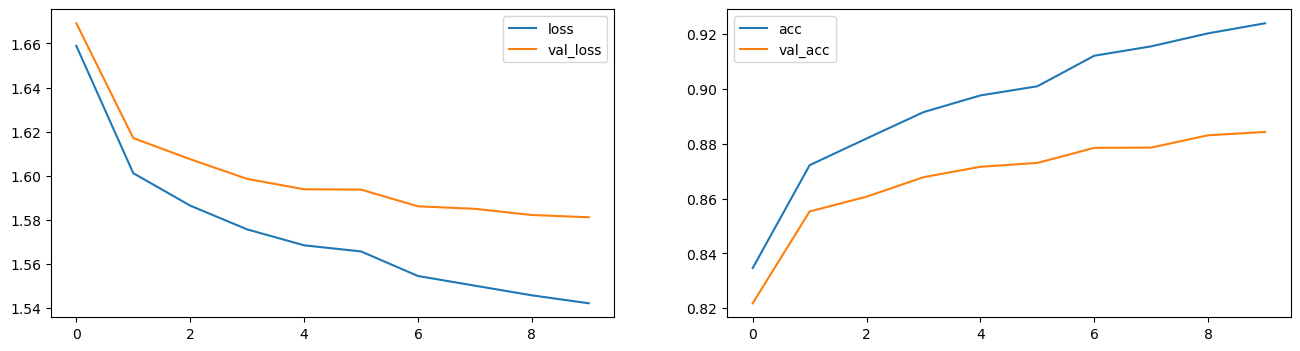

In [75]:
vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

<a id="4"></a>
# 4. Полезные ссылки
- [Курс "Deep learning на пальцах", лекция 4](https://youtu.be/tnrbx7V9RbA)
- [Статья: Методы оптимизации нейронных сетей](https://habr.com/ru/post/318970/)
- YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
- PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
- PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

Полезные ссылки 2.0:
- [Инициализация весов](https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/)
- [Почему инициализация весов нулями плохая идея?](https://habr.com/ru/articles/592711/)
- [Тонкости обучения нейронных сетей](https://education.yandex.ru/handbook/ml/article/tonkosti-obucheniya#inicializiruem-pravilno): инициализация, оптимизация, регуляризация
- [Подробнее про оптимизацию](https://education.yandex.ru/handbook/ml/article/optimizaciya-v-ml)